# Machine Learning Analyses

In [1]:
import os
import yaml
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import sys

In [2]:
# Local packages
sys.path.append('../src')
import ml_tools_wc as wc

In [3]:
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier

In [4]:
import numpy as np
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from itertools import compress

In [5]:
import sklearn
print(sklearn.__version__)

0.23.2


In [6]:
# Global random state (not a perfect setter of randoms states)
randn=888
np.random.seed(randn)

# Getting back the objects:
with open('../config/lists_radio.pkl', 'rb') as f:
    id_cols_radio,var_cols_radio,time_points,delta_time = pickle.load(f)

with open('../config/lists_path.pkl', 'rb') as f:
    id_cols_path,var_cols_path = pickle.load(f)
    
with open('../config/lists_imm.pkl', 'rb') as f:
    id_cols_imm,var_cols_imm = pickle.load(f)
    
with open('../config/lists_FeatureSelect.pkl', 'rb') as f:
    var_cols_FS = pickle.load(f)

with open('../config/lists_LogFI.pkl', 'rb') as f:
    var_cols_LogFI = pickle.load(f)[0]
    
id_cols = id_cols_radio + id_cols_path + id_cols_imm + ['Class_name']
var_cols = var_cols_radio + var_cols_path + var_cols_imm
    
#Retreive local data path
with open('../config/paths.yaml','r') as file:
    paths_list = yaml.safe_load(file)
    PATH = os.path.abspath(paths_list['PATH'])
    
# Get master log file
# Load file, create if not created
master_log_file = os.path.join(PATH,'tables','master_log.csv')
    
# Open cleaned data
data = pd.read_csv(os.path.join(PATH,'tables','data_merge246.csv'))
data.head()

,Subject,StudyDay,Abolute_Neutrophil,Absolute_Basophil,Absolute_Eosinophil,Absolute_Lymphocyte,Absolute_Monocyte,Absolute_Reticulocyte,Age_d,Alanine_Aminotransferase,...,IL-8,MCP-1,MIP-1alpha,MIP-1beta,STUDY_NO_imm,TGF-alpha,TNF-alpha,VEGF,sCD40L,Class_name
0,B03757,2_delta,-2.90,-0.02,0.00,-1.28,0.39,-36.0,1602.0,-1.0,...,124.26,510.64,36.33,22.94,NaN,1.84,2.14,7.28,604.50,Infected
1,B03757,4_delta,-2.93,-0.02,0.03,-0.55,0.82,-38.2,1604.0,4.0,...,165.65,393.94,33.04,18.52,NaN,10.47,18.12,3.46,689.80,Infected
2,B03757,6_delta,-2.18,-0.01,0.04,-0.67,0.87,-52.8,1606.0,-8.0,...,90.74,242.25,53.29,10.73,NaN,78.16,421.31,280.70,528.85,Infected
3,B03781,2_delta,-6.32,-0.01,-0.06,-2.27,-0.37,-28.2,1600.0,25.0,...,67.59,103.44,2.00,2.20,NaN,0.00,15.23,-0.33,2.91,Infected
4,B03781,4_delta,-7.35,-0.01,-0.01,-1.61,-0.21,-29.4,1602.0,13.0,...,51.39,0.14,0.00,-1.41,NaN,0.00,1.17,-3.02,-9.84,Infected


In [7]:
var_cols_radio# + var_cols_path + var_cols_imm

['VoxelVolume-shape',
 'Maximum3DDiameter-shape',
 'Compactness2-shape',
 'MeshVolume-shape',
 'MajorAxisLength-shape',
 'Sphericity-shape',
 'LeastAxisLength-shape',
 'Elongation-shape',
 'Compactness1-shape',
 'Flatness-shape',
 'SurfaceArea-shape',
 'MinorAxisLength-shape',
 'Maximum2DDiameterColumn-shape',
 'SphericalDisproportion-shape',
 'Maximum2DDiameterRow-shape',
 'JointAverage-glcm',
 'Autocorrelation-glcm',
 'JointEntropy-glcm',
 'ClusterShade-glcm',
 'Idmn-glcm',
 'JointEnergy-glcm',
 'Contrast-glcm',
 'DifferenceVariance-glcm',
 'Idn-glcm',
 'Idm-glcm',
 'Correlation-glcm',
 'SumAverage-glcm',
 'SumEntropy-glcm',
 'MCC-glcm',
 'SumSquares-glcm',
 'ClusterProminence-glcm',
 'Imc2-glcm',
 'Imc1-glcm',
 'DifferenceAverage-glcm',
 'Id-glcm',
 'ClusterTendency-glcm',
 'GrayLevelVariance-gldm',
 'HighGrayLevelEmphasis-gldm',
 'DependenceEntropy-gldm',
 'DependenceNonUniformity-gldm',
 'GrayLevelNonUniformity-gldm',
 'SmallDependenceHighGrayLevelEmphasis-gldm',
 'LargeDependence

# Adjust Analysis

In [8]:
note_init=''

In [9]:
useFS = False # Bool to run feature selection
#var_cols = var_cols_radio
#var_cols = var_cols_imm + var_cols_path

#note_init = '_radioOnly_'
#note_init = '_immOnly_'
#note_init = '_pathimmOnly_'

# Run Analysis

In [10]:
#Write status message, change this anytime this part of the analysis changes
status='time:d2d4d6'
with open(os.path.join('..','config','analysis_status','zz_time.txt'),'w') as out_file:
    out_file.write(status)

In [11]:
len(data)

60

In [12]:
print("Radiomics Features:",len(var_cols_radio))
print("Clinical Pathology Features:",len(var_cols_path))
print("Immunology Features:",len(var_cols_imm))

Radiomics Features: 90
Clinical Pathology Features: 25
Immunology Features: 22


In [13]:
def get_modality(name):
    if name in var_cols_radio:
        return 'Radiomics'
    elif name in var_cols_path:
        return 'Clinical Pathology'
    elif name in var_cols_imm:
        return 'Immunology'

In [14]:
def get_master_log(master_log_file):
    if os.path.isfile(master_log_file):
        master_log = pd.read_csv(master_log_file)
    else:
        # Create a new log spreadsheet
        master_log = pd.DataFrame(columns=['Date','Model','AUC','CVaccuracy','CVf1','Note'])
    #master_log.tail()
    
    # Log status of original masterlog
    #last_note = master_log.iloc[-1]['Note']
    old_note_list = master_log.Note.unique()
    return master_log,old_note_list

## Fine-tune variables to include in analysis

In [15]:
# Use a subset of the total available columns dictated by feature selection script
if useFS:
    var_cols = var_cols_FS
    fs_status='FS:'+str(len(var_cols))+note_init
else:
    fs_status='noFS:'+str(len(var_cols))+note_init
#var_cols = var_cols_LogFI

In [16]:
len(data)

60

In [17]:
# # z-score normalize, this is done in the pipe
# for var in var_cols:
#     data[var] = (data[var]-data[var].mean()) / data[var].std()

#Write status message, change this anytime this part of the analysis changes
status='z-norm,groupSubj,'+fs_status
with open(os.path.join('..','config','analysis_status','yb_znorm.txt'),'w') as out_file:
    out_file.write(status)

In [18]:
# tmp = data.groupby(['StudyDay','Class']).agg('count')
# for var in var_cols:
#     print('----'+var+'----')
#     if len(tmp.loc[tmp[var] < 12,var]) > 0:
#         print('********* HERE **********')
#         display(tmp.loc[tmp[var] < 12,var])

In [19]:
data.groupby(['StudyDay','Class']).describe()

Abolute_Neutrophil                                           \
                            count      mean       std   min     25%    50%   
StudyDay Class                                                               
2_delta  0                    8.0  0.312500  1.315042 -1.05 -0.6200 -0.180   
         1                   12.0 -0.545000  3.357695 -6.32 -1.7525 -1.315   
4_delta  0                    8.0  0.230000  2.115555 -2.86 -1.3350  0.585   
         1                   12.0 -1.158333  2.269893 -7.35 -1.4875 -0.790   
6_delta  0                    8.0  0.182500  1.349473 -1.23 -0.8325 -0.365   
         1                   12.0 -1.326667  1.925042 -6.35 -1.5650 -0.975   

                             Absolute_Basophil            ...     VEGF  \
                   75%   max             count      mean  ...      75%   
StudyDay Class                                            ...            
2_delta  0      1.3525  2.36               8.0  0.007500  ...  16.8300   
         1      0.0150  7.62              12.0 -0.008333  ...   7.3125   
4_delta  0      1.3300  3.59               8.0  0.001250  ...   9.0650   
         1      0.4525  1.04              12.0 -0.008333  ...   4.2925   
6_delta  0      1.1925  2.50               8.0  0.002500  ...   0.8425   
         1     -0.2450  0.77              12.0 -0.005833  ...  18.4250   

                       sCD40L                                            \
                   max  count        mean          std     min      25%   
StudyDay Class                                                            
2_delta  0       22.22    8.0  150.262500   315.301617   -3.45  11.4775   
         1       25.89   12.0  821.501667  2017.645788  -71.86 -27.2775   
4_delta  0       20.79    8.0   80.880000   113.001229   -4.46   3.9150   
         1       41.94   12.0    8.404167   233.337344 -324.24 -39.0575   
6_delta  0      175.14    8.0   27.232500    80.561247  -71.40  -7.9025   
         1      280.70   12.0  211.788333   467.117429  -48.81  -8.7200   

                                           
                   50%       75%      max  
StudyDay Class                             
2_delta  0      30.255   71.2225   919.00  
         1       1.020  188.8500  6757.06  
4_delta  0      33.940  109.3675   321.87  
         1     -16.050    0.7600   689.80  
6_delta  0       0.865   38.4750   187.60  
         1       2.350  180.5425  1590.27  

[6 rows x 1464 columns]

#### Scaling and enumerating

In [20]:
# # Enumerate Class
# data.loc[data["Class"] == "Infected","Class"] = 1
# data.loc[data["Class"] == "Mock","Class"] = 0

#### Create Note

In [21]:
def get_note(status_dir,old_note_list):
    note = ''
    for filename in os.listdir(status_dir):
        if not filename.startswith('.'):
            with open(os.path.join(status_dir,filename), 'r') as f:
                subnote = f.read() + ';'
            note = note + subnote
            
    while note in old_note_list:
        note = 'copy-'+note

    return note

### ML functions

In [22]:
def assess_MLmodel(model,X,y,note_ml='tmp',title_plot="",export_plot=False):
    
    print('----- %s -----' % (model))
    
    var_cols_tmp = X.columns[X.columns != 'Subject']

    #     # z-score normalize, this is done in the pipe
    #     for var in var_cols_tmp:
    #         X[var] = (X[var]-X[var].mean()) / X[var].std()

    # ---- split into train/test sets ----
    # Traditional train/test split
    #trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=8)
    # Grouped train/test split (keep from splitting subjects across train/test groups)
    gss = GroupShuffleSplit(n_splits=2, train_size=0.7, random_state=randn)
    #gss = GroupShuffleSplit(n_splits=5, random_state=randn)
    #gss = GroupShuffleSplit(n_splits=2, train_size=0.7)
    train_ix, test_ix = next(gss.split(X, y, groups=X.Subject))
    trainX = X.iloc[train_ix][var_cols_tmp]
    testX = X.iloc[test_ix][var_cols_tmp]
    trainy = y.iloc[train_ix].Class.astype(int)
    testy = y.iloc[test_ix].Class.astype(int)

    print(X.iloc[train_ix].Subject.unique())
    print(X.iloc[test_ix].Subject.unique())
    print('Training samples:',len(trainX), '(', trainy.to_numpy().sum(),' infected)')
    print('Testing sample:',len(testX), '(', testy.to_numpy().sum(),' infected)')
    print('Unique training subjects:',len(set(X.iloc[train_ix].Subject)))
    print('Unique testing subjects:',len(set(X.iloc[test_ix].Subject)))
    print('Features:',len(trainX.columns))
    # Remove the subject ID for later use, important that order matches X
    subj_ids = X.Subject
    X = X[var_cols_tmp]
    y = y.Class.astype(int)
    
    # Make pipeline (to add scaling before training and testing)
    #    Scale too mean of 0 and STD of 1 then apply the model
    #    Scalling is essential for calculating feature importance
    pipe = Pipeline([('z-norm',StandardScaler()), ('ml_model',model)])
        
    # ---- Train model and calculate AUC on test set ----
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]
    
    # fit a model
    fitted_model = pipe.fit(trainX, trainy)
    
    # predict probabilities
    lr_probs = pipe.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('ROC AUC=%.3f' % (lr_auc))
    
    # ---- Calculate Cross-validation accuracy on entire dateset ----
    folds=5
    gss = GroupShuffleSplit(n_splits=folds, train_size=0.7, random_state=randn)
    
    # Show iterations to check for a decent mock/infected split
    for train_tmp, test_tmp in gss.split(X, y, groups=subj_ids):
        print('Train:',subj_ids[train_tmp].unique())
        print('Test:',subj_ids[test_tmp].unique())
        print('Train_Exposed:',y.iloc[train_tmp].tolist().count(1),'Train_Mock:',y.iloc[train_tmp].tolist().count(0))
        print('Test_Exposed:',y.iloc[test_tmp].tolist().count(1),'Test_Mock:',y.iloc[test_tmp].tolist().count(0))
        
    
    #CVscores = cross_validate(pipe, X, y, cv=folds, scoring=['accuracy','f1','roc_auc'])
    CVscores = cross_validate(pipe, X, y, cv=gss.split(X, y, groups=subj_ids), scoring=['accuracy','f1','roc_auc'])
        
    display(CVscores)
    print("Cross-validation Accuracy: %0.2f (+/- %0.2f)" % (CVscores['test_accuracy'].mean(), CVscores['test_accuracy'].std() * 2))
    print("Cross-validation F1: %0.2f (+/- %0.2f)" % (CVscores['test_f1'].mean(), CVscores['test_f1'].std() * 2))
    print("Cross-validation ROC AUC: %0.2f (+/- %0.2f)" % (CVscores['test_roc_auc'].mean(), CVscores['test_roc_auc'].std() * 2))
    # run with shuffle
    #     cv = ShuffleSplit(n_splits=folds, test_size=0.2, random_state=7)
    #     SSCVscores = cross_val_score(pipe, X, y, cv=cv)
    #     print("Shuffle CV Accuracy: %0.2f (+/- %0.2f)" % (SSCVscores.mean(), SSCVscores.std() * 2))
    
    # ---- Save performance ----
    log = pd.DataFrame(data={'Date':datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                             'Model':str(model),
                             'AUC':lr_auc,
                             'CVaccuracy':CVscores['test_accuracy'].mean(),
                             'CVf1':CVscores['test_f1'].mean(),
                             'Note':note_ml},index=[0])
   
    # ---- Calculate/plot roc curves ----
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, drop_intermediate=False)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, drop_intermediate=False)
    
    print('fpr:',lr_fpr)
    print('tpr:',lr_tpr)
    
    # plot the roc curve for the model
    fig = plt.figure()
    axs = fig.add_subplot()
    axs.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    axs.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    #axs.plot(testy, lr_probs, marker='.', label='Model')
    # axis labels
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    if title_plot:
        axs.set_title(title_plot)
    # show the legend
    axs.legend()
    # save the plot
        # As written, only the last of each model type is saved (ex. one logistic regression plot)
    if export_plot == True:
        fig.savefig(os.path.join(PATH,'figures','Output_mlplot_'+re.split('\(|\)',type(model).__name__)[0]+'.png'),dpi=600,bbox_inches='tight')
    # show the plot
    plt.show()
    
    # ---- Output feature ranking ----
    #print(abs(fitted_model['ml_model'].coef_[0]))

    feature_imp = pd.DataFrame({'feature':X.columns.tolist()})

    try:
        feature_imp['score_val'] = abs(fitted_model['ml_model'].coef_[0])
        print('Ranking based on coefficient')
    except:
        print('Not a valid model for feature ranking based on coefficient')

        try:
            feature_imp['score_val'] = fitted_model['ml_model'].feature_importances_
            print('Ranking based on feature importance')
        except:
            print('Not a valid model for feature ranking based on feature importance')
            return [log,None]

    feature_imp = feature_imp.sort_values(by='score_val',ascending=False).round(2).reset_index().drop('index',axis='columns')

    #     # Calculate a score threshold for more than 34 features
    #     n_feature_count=34
    #     if len(X.columns) > n_feature_count:
    #         score_val_thresh = feature_imp.score_val.iloc[n_feature_count]
    #         feature_imp = feature_imp.loc[feature_imp.score_val >= score_val_thresh]
    #         print('Score threshold for n =',n_feature_count,':',score_val_thresh)
    return [log,feature_imp]

In [23]:
def ml_test(field_list,data_tmp,master_log_file):
    # Inputs:
    # 1) list of fields in data_tmp_clean to input into the machine learner
    # 2) enumerate each group or set to None to exclude group
    master_log,old_note_list = get_master_log(master_log_file)
    
    note_ml = get_note(os.path.join('..','config','analysis_status'), old_note_list)
    print(note_ml)
    
    X = data_tmp[field_list+['Subject']] # need subject field for GroupShuffleSplit
    y = data_tmp[['Class','Subject']]
    class0_label = 'Mock'
    class1_label = 'SARs-CoV-2'
    
    print('---- Fields ----')
    print(field_list)
    title_plot = class1_label + ' vs. ' + class0_label
    
    # List of models to evaluate
    model_array=[LogisticRegression(),LogisticRegression(solver='liblinear', multi_class='ovr'),
             SVC(probability=True),SVC(kernel='linear', probability=True),
             DecisionTreeClassifier(),RandomForestClassifier(),
             KNeighborsClassifier(),GaussianNB(),
             LinearDiscriminantAnalysis(),XGBClassifier(use_label_encoder=False,eval_metric='logloss')
            ]

    # For each model type, train and evaluate the results
    for model_i in model_array:
        tmp_df,coef = assess_MLmodel(model_i,X,y,note_ml,str(model_i))
        master_log = master_log.append(tmp_df,ignore_index=True)
        if coef is not None:
            print('Top 17 coefficients:')
            display(coef[:17])
            
    # View the master log
    display(master_log.tail(18))
    
    # Plot the difference between the previous iteration and this iteration
    plot_diff = wc.plot_mlperformance(master_log,['old','new'],[old_note_list[-1],note_ml])[0]
    display(plot_diff)
    
    # Display note
    print('Note: '+note_ml)
    
    # Temporary, don't ask to save results
    #note_ml='copy-'
    
    # Decide to save the master log
    if note_ml[:5] != 'copy-': 
        save_results = input("Save results to the log file? (y/n):")
        if save_results == 'y':
            master_log.set_index('Date').to_csv(master_log_file)
            print('Saving results to master_log')
        else:
            print('Not storing results')
    else:
        print('Not saving a copy to the master log file, add something descriptive to the note to distinguish it from the others')
    return master_log

## Run base analysis with all features

noFS:137
----- LogisticRegression() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=1.000
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942' 'G26Y' 

{'fit_time': array([0.01954937, 0.01891661, 0.02148461, 0.01983762, 0.02033234]),
 'score_time': array([0.01341414, 0.01186705, 0.01212597, 0.01438928, 0.0119102 ]),
 'test_accuracy': array([0.88888889, 1.        , 0.5       , 0.94444444, 1.        ]),
 'test_f1': array([0.90909091, 1.        , 0.4       , 0.95652174, 1.        ]),
 'test_roc_auc': array([1., 1., 1., 1., 1.])}

Cross-validation Accuracy: 0.87 (+/- 0.38)
Cross-validation F1: 0.85 (+/- 0.46)
Cross-validation ROC AUC: 1.00 (+/- 0.00)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.         1.         1.         1.         1.
 1.        ]


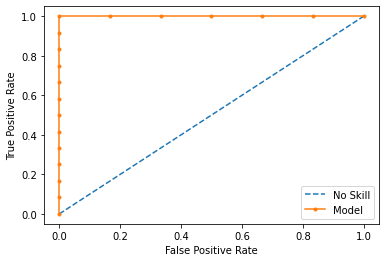

Ranking based on coefficient


[                  Date                 Model  AUC  CVaccuracy      CVf1 Note
 0  2022-04-08 10:03:09  LogisticRegression()  1.0    0.866667  0.853123  tmp,
                           feature  score_val
 0             Blood_Urea_Nitrogen       0.46
 1               Absolute_Basophil       0.37
 2           Absolute_Reticulocyte       0.35
 3                  Contrast-ngtdm       0.32
 4                       Idmn-glcm       0.31
 ..                            ...        ...
 132  RunLengthNonUniformity-glrlm       0.00
 133                     IFN-gamma       0.00
 134                         IL-10       0.00
 135                         IL-18       0.00
 136                IL-12_23_(p40)       0.00
 
 [137 rows x 2 columns]]

In [24]:
# Test condition
print(fs_status)
assess_MLmodel(LogisticRegression(),data[var_cols+['Subject']],data[['Class','Subject']])

CoopExcl;SexOriginBal;elasticnet:74;radioExcl_MC;;z-norm,groupSubj,noFS:137;time:d2d4d6;MRMR-permute 0.05;
---- Fields ----
['VoxelVolume-shape', 'Maximum3DDiameter-shape', 'Compactness2-shape', 'MeshVolume-shape', 'MajorAxisLength-shape', 'Sphericity-shape', 'LeastAxisLength-shape', 'Elongation-shape', 'Compactness1-shape', 'Flatness-shape', 'SurfaceArea-shape', 'MinorAxisLength-shape', 'Maximum2DDiameterColumn-shape', 'SphericalDisproportion-shape', 'Maximum2DDiameterRow-shape', 'JointAverage-glcm', 'Autocorrelation-glcm', 'JointEntropy-glcm', 'ClusterShade-glcm', 'Idmn-glcm', 'JointEnergy-glcm', 'Contrast-glcm', 'DifferenceVariance-glcm', 'Idn-glcm', 'Idm-glcm', 'Correlation-glcm', 'SumAverage-glcm', 'SumEntropy-glcm', 'MCC-glcm', 'SumSquares-glcm', 'ClusterProminence-glcm', 'Imc2-glcm', 'Imc1-glcm', 'DifferenceAverage-glcm', 'Id-glcm', 'ClusterTendency-glcm', 'GrayLevelVariance-gldm', 'HighGrayLevelEmphasis-gldm', 'DependenceEntropy-gldm', 'DependenceNonUniformity-gldm', 'GrayLevel

{'fit_time': array([0.02296519, 0.02108669, 0.02513909, 0.02278113, 0.02031708]),
 'score_time': array([0.01187277, 0.01598239, 0.01207733, 0.01198983, 0.01186275]),
 'test_accuracy': array([0.88888889, 1.        , 0.5       , 0.94444444, 1.        ]),
 'test_f1': array([0.90909091, 1.        , 0.4       , 0.95652174, 1.        ]),
 'test_roc_auc': array([1., 1., 1., 1., 1.])}

Cross-validation Accuracy: 0.87 (+/- 0.38)
Cross-validation F1: 0.85 (+/- 0.46)
Cross-validation ROC AUC: 1.00 (+/- 0.00)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.         1.         1.         1.         1.
 1.        ]


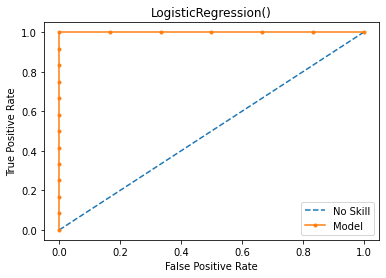

Ranking based on coefficient
Top 17 coefficients:


,feature,score_val
0,Blood_Urea_Nitrogen,0.46
1,Absolute_Basophil,0.37
2,Absolute_Reticulocyte,0.35
3,Contrast-ngtdm,0.32
4,Idmn-glcm,0.31
5,White_Blood_Cell_,0.30
6,Abolute_Neutrophil,0.28
7,LargeAreaLowGrayLevelEmphasis-glszm,0.24
8,ZoneVariance-glszm,0.24
9,LargeAreaEmphasis-glszm,0.24


----- LogisticRegression(multi_class='ovr', solver='liblinear') -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=1.000
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test

{'fit_time': array([0.01707578, 0.01432681, 0.01112676, 0.0109694 , 0.01106381]),
 'score_time': array([0.01226711, 0.01465559, 0.01183987, 0.01193619, 0.01265645]),
 'test_accuracy': array([0.83333333, 1.        , 0.94444444, 0.94444444, 0.94444444]),
 'test_f1': array([0.85714286, 1.        , 0.85714286, 0.95652174, 0.94117647]),
 'test_roc_auc': array([1., 1., 1., 1., 1.])}

Cross-validation Accuracy: 0.93 (+/- 0.11)
Cross-validation F1: 0.92 (+/- 0.11)
Cross-validation ROC AUC: 1.00 (+/- 0.00)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.         1.         1.         1.         1.
 1.        ]


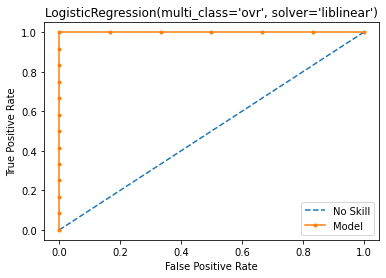

Ranking based on coefficient
Top 17 coefficients:


,feature,score_val
0,Blood_Urea_Nitrogen,0.51
1,Absolute_Basophil,0.40
2,Contrast-ngtdm,0.38
3,Absolute_Reticulocyte,0.34
4,White_Blood_Cell_,0.32
5,Idmn-glcm,0.31
6,LargeAreaLowGrayLevelEmphasis-glszm,0.31
7,ZoneVariance-glszm,0.30
8,LargeAreaEmphasis-glszm,0.30
9,Abolute_Neutrophil,0.28


----- SVC(probability=True) -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=1.000
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942' 'G26Y' 'G57L' '

{'fit_time': array([0.01283693, 0.01254797, 0.01170158, 0.01229763, 0.01179361]),
 'score_time': array([0.01631236, 0.01304793, 0.01229644, 0.01253653, 0.0133307 ]),
 'test_accuracy': array([0.94444444, 0.94444444, 0.38888889, 1.        , 0.88888889]),
 'test_f1': array([0.95652174, 0.94736842, 0.35294118, 1.        , 0.88888889]),
 'test_roc_auc': array([1.        , 1.        , 1.        , 1.        , 0.98765432])}

Cross-validation Accuracy: 0.83 (+/- 0.45)
Cross-validation F1: 0.83 (+/- 0.48)
Cross-validation ROC AUC: 1.00 (+/- 0.01)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.         1.         1.         1.         1.
 1.        ]


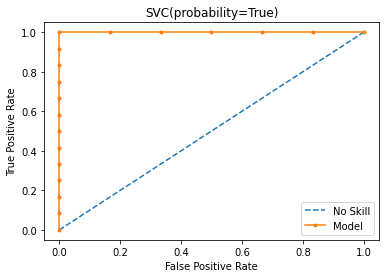

Not a valid model for feature ranking based on coefficient
Not a valid model for feature ranking based on feature importance
----- SVC(kernel='linear', probability=True) -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=0.986
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B037

{'fit_time': array([0.01142406, 0.0141623 , 0.01409125, 0.01426506, 0.01444006]),
 'score_time': array([0.0119319 , 0.01196408, 0.0120523 , 0.01207399, 0.01201916]),
 'test_accuracy': array([0.88888889, 1.        , 0.61111111, 0.88888889, 1.        ]),
 'test_f1': array([0.90909091, 1.        , 0.46153846, 0.90909091, 1.        ]),
 'test_roc_auc': array([0.98611111, 1.        , 1.        , 0.98611111, 1.        ])}

Cross-validation Accuracy: 0.88 (+/- 0.28)
Cross-validation F1: 0.86 (+/- 0.40)
Cross-validation ROC AUC: 0.99 (+/- 0.01)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.16666667 0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 0.91666667 1.         1.         1.         1.         1.
 1.        ]


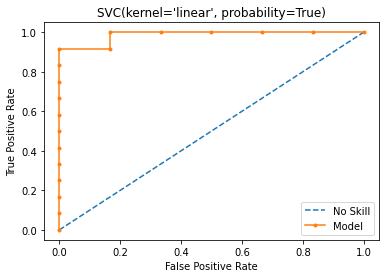

Ranking based on coefficient
Top 17 coefficients:


,feature,score_val
0,Blood_Urea_Nitrogen,0.15
1,Absolute_Basophil,0.11
2,Absolute_Reticulocyte,0.10
3,IL-17a,0.09
4,Contrast-ngtdm,0.09
5,White_Blood_Cell_,0.09
6,Abolute_Neutrophil,0.09
7,Idmn-glcm,0.09
8,Platelet,0.08
9,Flatness-shape,0.08


----- DecisionTreeClassifier() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=0.958
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942' 'G26Y' 'G57L

{'fit_time': array([0.01732087, 0.01564312, 0.01651073, 0.0147121 , 0.01550531]),
 'score_time': array([0.01236916, 0.01172352, 0.01171684, 0.01154089, 0.01158881]),
 'test_accuracy': array([0.94444444, 0.72222222, 0.72222222, 0.88888889, 0.94444444]),
 'test_f1': array([0.95652174, 0.7826087 , 0.44444444, 0.92307692, 0.94736842]),
 'test_roc_auc': array([0.95833333, 0.72222222, 0.7       , 0.83333333, 0.94444444])}

Cross-validation Accuracy: 0.84 (+/- 0.20)
Cross-validation F1: 0.81 (+/- 0.39)
Cross-validation ROC AUC: 0.83 (+/- 0.22)
fpr: [0. 0. 1.]
tpr: [0.         0.91666667 1.        ]


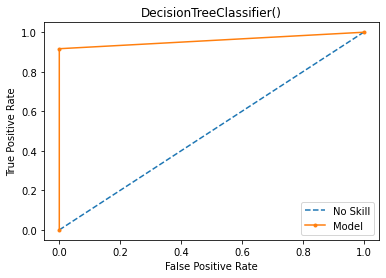

Not a valid model for feature ranking based on coefficient
Ranking based on feature importance
Top 17 coefficients:


,feature,score_val
0,Busyness-ngtdm,0.82
1,Absolute_Lymphocyte,0.09
2,AlbuminvGlobulin_Ratio,0.09
3,VoxelVolume-shape,0.00
4,Absolute_Monocyte,0.00
5,Contrast-ngtdm,0.00
6,Abolute_Neutrophil,0.00
7,Absolute_Basophil,0.00
8,Absolute_Eosinophil,0.00
9,Absolute_Reticulocyte,0.00


----- RandomForestClassifier() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=1.000
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942' 'G26Y' 'G57L

{'fit_time': array([0.18634248, 0.18540668, 0.18285799, 0.18425083, 0.18637538]),
 'score_time': array([0.0391717 , 0.0390017 , 0.03893328, 0.03881526, 0.03934479]),
 'test_accuracy': array([0.88888889, 0.94444444, 0.66666667, 0.94444444, 0.94444444]),
 'test_f1': array([0.92307692, 0.94736842, 0.5       , 0.96      , 0.94736842]),
 'test_roc_auc': array([0.97222222, 1.        , 0.8       , 1.        , 1.        ])}

Cross-validation Accuracy: 0.88 (+/- 0.22)
Cross-validation F1: 0.86 (+/- 0.36)
Cross-validation ROC AUC: 0.95 (+/- 0.16)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.16666667 0.33333333 0.5        0.83333333 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667 1.
 1.         1.         1.         1.         1.        ]


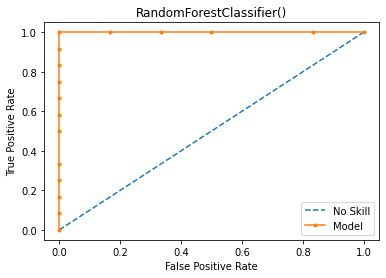

Not a valid model for feature ranking based on coefficient
Ranking based on feature importance
Top 17 coefficients:


,feature,score_val
0,RobustMeanAbsoluteDeviation-firstorder,0.06
1,Busyness-ngtdm,0.06
2,Idmn-glcm,0.05
3,Strength-ngtdm,0.05
4,InterquartileRange-firstorder,0.05
5,LowGrayLevelRunEmphasis-glrlm,0.04
6,HighGrayLevelEmphasis-gldm,0.03
7,IL-15,0.03
8,SumAverage-glcm,0.03
9,GrayLevelNonUniformity-gldm,0.03


----- KNeighborsClassifier() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=0.958
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942' 'G26Y' 'G57L' 

{'fit_time': array([0.01010108, 0.00995493, 0.01037788, 0.01011539, 0.00995922]),
 'score_time': array([0.01482081, 0.01458955, 0.01564956, 0.01507497, 0.01551843]),
 'test_accuracy': array([0.83333333, 1.        , 0.72222222, 0.66666667, 0.88888889]),
 'test_f1': array([0.85714286, 1.        , 0.54545455, 0.66666667, 0.875     ]),
 'test_roc_auc': array([0.95833333, 1.        , 0.93333333, 0.91666667, 0.97530864])}

Cross-validation Accuracy: 0.82 (+/- 0.24)
Cross-validation F1: 0.79 (+/- 0.32)
Cross-validation ROC AUC: 0.96 (+/- 0.06)
fpr: [0. 0. 0. 0. 0. 1.]
tpr: [0.         0.25       0.58333333 0.75       0.91666667 1.        ]


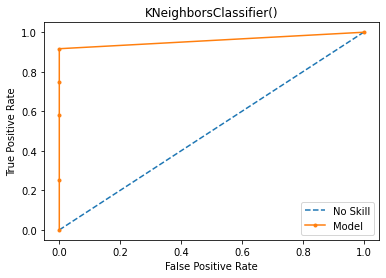

Not a valid model for feature ranking based on coefficient
Not a valid model for feature ranking based on feature importance
----- GaussianNB() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=0.917
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03

{'fit_time': array([0.01156402, 0.01092148, 0.01036191, 0.01075912, 0.0103724 ]),
 'score_time': array([0.01442552, 0.01217437, 0.01201296, 0.01241398, 0.01206088]),
 'test_accuracy': array([0.94444444, 0.77777778, 0.55555556, 0.88888889, 0.88888889]),
 'test_f1': array([0.96      , 0.81818182, 0.33333333, 0.92307692, 0.9       ]),
 'test_roc_auc': array([0.91666667, 0.77777778, 0.71111111, 0.81944444, 0.94444444])}

Cross-validation Accuracy: 0.81 (+/- 0.28)
Cross-validation F1: 0.79 (+/- 0.46)
Cross-validation ROC AUC: 0.83 (+/- 0.17)
fpr: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0. 1. 1. 1. 1. 1. 1.]


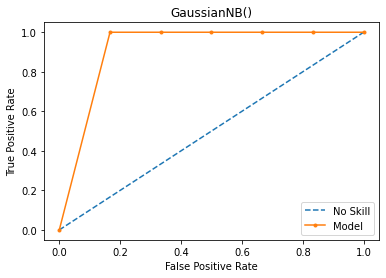

Not a valid model for feature ranking based on coefficient
Not a valid model for feature ranking based on feature importance
----- LinearDiscriminantAnalysis() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=0.986
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B0381

{'fit_time': array([0.05946231, 0.06752515, 0.04979277, 0.03767443, 0.0640111 ]),
 'score_time': array([0.02202463, 0.02533627, 0.03344417, 0.02876616, 0.03607249]),
 'test_accuracy': array([0.88888889, 0.88888889, 0.5       , 0.83333333, 0.83333333]),
 'test_f1': array([0.90909091, 0.875     , 0.4       , 0.85714286, 0.84210526]),
 'test_roc_auc': array([0.98611111, 1.        , 0.95555556, 0.86111111, 0.97530864])}

Cross-validation Accuracy: 0.79 (+/- 0.29)
Cross-validation F1: 0.78 (+/- 0.38)
Cross-validation ROC AUC: 0.96 (+/- 0.10)
fpr: [0.         0.         0.         0.         0.         0.16666667
 0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ]
tpr: [0.         0.66666667 0.75       0.83333333 0.91666667 0.91666667
 1.         1.         1.         1.         1.         1.        ]


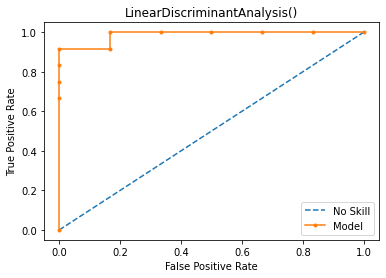

Ranking based on coefficient
Top 17 coefficients:


,feature,score_val
0,Platelet,30.20
1,Absolute_Basophil,28.31
2,MIP-1beta,13.50
3,TNF-alpha,13.37
4,Hemoglobin,13.17
5,LargeAreaLowGrayLevelEmphasis-glszm,13.12
6,Median-firstorder,12.71
7,Compactness2-shape,12.21
8,Red_Cell_Distrubtion_Width_-_Standard_De,11.47
9,SmallDependenceHighGrayLevelEmphasis-gldm,11.41


----- XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None) -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing

{'fit_time': array([8.4807725 , 8.26221609, 7.6483407 , 8.07212687, 8.38672972]),
 'score_time': array([0.0801723 , 0.06917715, 0.05744314, 0.05701756, 0.08459544]),
 'test_accuracy': array([1.        , 0.94444444, 0.77777778, 0.88888889, 0.94444444]),
 'test_f1': array([1.        , 0.94736842, 0.5       , 0.92307692, 0.94736842]),
 'test_roc_auc': array([1.        , 0.99382716, 0.84444444, 0.97916667, 1.        ])}

Cross-validation Accuracy: 0.91 (+/- 0.15)
Cross-validation F1: 0.86 (+/- 0.37)
Cross-validation ROC AUC: 0.96 (+/- 0.12)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.16666667 0.33333333 0.66666667 0.83333333 1.        ]
tpr: [0.         0.08333333 0.16666667 0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667 1.
 1.         1.         1.         1.         1.        ]


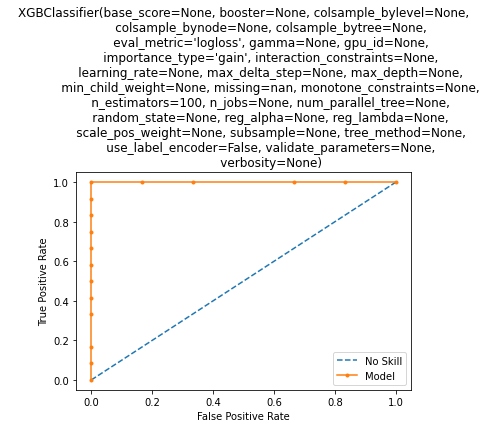

Not a valid model for feature ranking based on coefficient
Ranking based on feature importance
Top 17 coefficients:


,feature,score_val
0,Busyness-ngtdm,0.32
1,Strength-ngtdm,0.18
2,InterquartileRange-firstorder,0.13
3,Correlation-glcm,0.07
4,Idmn-glcm,0.06
5,Blood_Urea_Nitrogen,0.06
6,Absolute_Reticulocyte,0.04
7,TotalEnergy-firstorder,0.04
8,IL-15,0.03
9,Maximum2DDiameterRow-shape,0.02


,Date,Model,AUC,CVaccuracy,CVf1,Note
861,2021-12-07 10:55:27,SVC(probability=True),0.930556,0.588889,0.683750,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
862,2021-12-07 10:55:27,"SVC(kernel='linear', probability=True)",0.819444,0.655556,0.659272,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
863,2021-12-07 10:55:27,DecisionTreeClassifier(),0.708333,0.633333,0.654017,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
864,2021-12-07 10:55:29,RandomForestClassifier(),0.715278,0.700000,0.733153,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
865,2021-12-07 10:55:29,KNeighborsClassifier(),0.694444,0.544444,0.571033,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
866,2021-12-07 10:55:30,GaussianNB(),0.847222,0.766667,0.742458,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
867,2021-12-07 10:55:30,LinearDiscriminantAnalysis(),0.805556,0.588889,0.597946,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
868,2021-12-07 10:55:50,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.861111,0.755556,0.770112,"CoopExcl;SexOriginBal;radioExcl_MC;;z-norm,gro..."
869,2022-04-08 10:03:09,LogisticRegression(),1.000000,0.866667,0.853123,CoopExcl;SexOriginBal;elasticnet:74;radioExcl_...
870,2022-04-08 10:03:10,"LogisticRegression(multi_class='ovr', solver='...",1.000000,0.933333,0.922397,CoopExcl;SexOriginBal;elasticnet:74;radioExcl_...


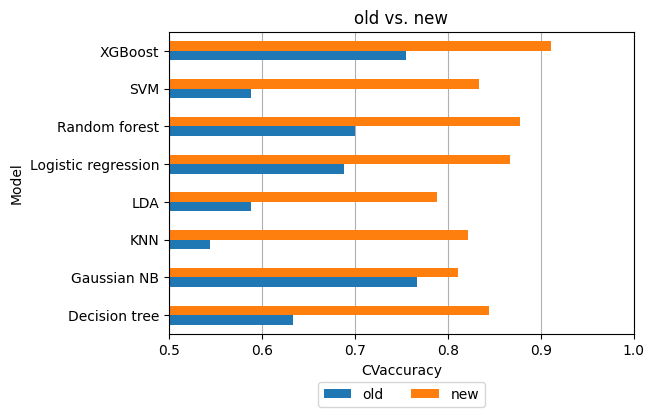

Note: CoopExcl;SexOriginBal;elasticnet:74;radioExcl_MC;;z-norm,groupSubj,noFS:137;time:d2d4d6;MRMR-permute 0.05;
Save results to the log file? (y/n):n
Not storing results


In [25]:
if True:
    # Make sure to clear the tmp file in case there was an error last time
    tmp_status_file=os.path.join('analysis_status','a_tmp.txt')
    if os.path.exists(tmp_status_file):
        os.remove(tmp_status_file)
    # Test multiple ML algorithms
    ml_log_tmp = ml_test(var_cols,data,master_log_file)

In [26]:
# single algorithm test condition
# var_cols_LogFI = assess_MLmodel(LogisticRegression(),data[var_cols+['Subject']],data[['Class','Subject']])[1]['feature'].tolist()
#assess_MLmodel(XGBClassifier(use_label_encoder=False,eval_metric='logloss'),data[var_cols+['Subject']],data[['Class','Subject']])


# Feature Selection based on Feature Importance

In [27]:
if False:
    plot_tmp,coef = assess_MLmodel(LogisticRegression(solver='liblinear', penalty='l1'),data[var_cols+['Subject']],data[['Class','Subject']])
    var_cols_tmp = coef.loc[coef.score_val > 0,'feature'].tolist()
    display(coef.loc[coef.score_val > 0])

----- LogisticRegression(penalty='l1', solver='liblinear') -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=1.000
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B

{'fit_time': array([0.0107317 , 0.01060009, 0.01066542, 0.01063442, 0.01073599]),
 'score_time': array([0.01180363, 0.0117898 , 0.01191783, 0.01185203, 0.01918721]),
 'test_accuracy': array([0.94444444, 0.94444444, 0.66666667, 1.        , 1.        ]),
 'test_f1': array([0.95652174, 0.94117647, 0.5       , 1.        , 1.        ]),
 'test_roc_auc': array([1., 1., 1., 1., 1.])}

Cross-validation Accuracy: 0.91 (+/- 0.25)
Cross-validation F1: 0.88 (+/- 0.38)
Cross-validation ROC AUC: 1.00 (+/- 0.00)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.         1.         1.         1.         1.
 1.        ]


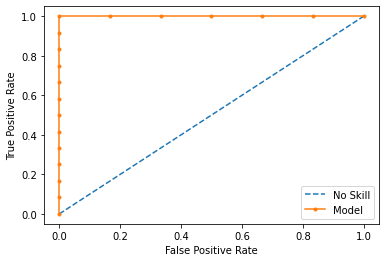

Ranking based on coefficient


,feature,score_val
0,Blood_Urea_Nitrogen,1.12
1,Idmn-glcm,0.90
2,LargeAreaLowGrayLevelEmphasis-glszm,0.86
3,Absolute_Basophil,0.85
4,Uniformity-firstorder,0.61
5,ZoneVariance-glszm,0.36
6,Busyness-ngtdm,0.23
7,Red_Cell_Distrubtion_Width_-_Coefficient,0.20
8,White_Blood_Cell_,0.16
9,LargeAreaEmphasis-glszm,0.13


Radiomics 6
Clinical Pathology 4
Immunology 0
Total 10


In [28]:
plot_tmp,coef = assess_MLmodel(LogisticRegression(solver='liblinear', penalty='l1'),data[var_cols+['Subject']],data[['Class','Subject']])
var_cols_tmp = coef.loc[coef.score_val > 0,'feature'].tolist()
display(coef.loc[coef.score_val > 0])
print('Radiomics',[get_modality(n) for n in var_cols_tmp].count('Radiomics'))
print('Clinical Pathology',[get_modality(n) for n in var_cols_tmp].count('Clinical Pathology'))
print('Immunology',[get_modality(n) for n in var_cols_tmp].count('Immunology'))
print('Total',len(var_cols_tmp))
if False:
    # save feature set
    tmp_df = pd.DataFrame({'var':var_cols_tmp,'mod':[get_modality(n) for n in var_cols_tmp]})
    tmp_df.to_csv(os.path.join(PATH,'tables','feature_list_lasso.csv'))
    print(os.path.join(PATH,'tables','feature_list_lasso.csv'))
    
if False:
    #Write status message, change this anytime this part of the analysis changes
    status='LASSO:'+str(len(var_cols_tmp))
    tmp_status_file=os.path.join('..','config','analysis_status','a_tmp.txt')
    with open(tmp_status_file,'w') as out_file:
        out_file.write(status)
    ml_log_tmp = ml_test(var_cols_tmp,data,master_log_file)
    del var_cols_tmp
    os.remove(tmp_status_file)

In [29]:
#y

----- LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga') -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=1.000
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 

/sysapps/cluster/software/Anaconda3/5.3.0/envs/pythonenv/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/sysapps/cluster/software/Anaconda3/5.3.0/envs/pythonenv/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/sysapps/cluster/software/Anaconda3/5.3.0/envs/pythonenv/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/sysapps/cluster/software/Anaconda3/5.3.0/envs/pythonenv/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", 

{'fit_time': array([0.02979016, 0.03475451, 0.02665162, 0.0269134 , 0.03066206]),
 'score_time': array([0.01268959, 0.01538062, 0.01271939, 0.01285601, 0.01256633]),
 'test_accuracy': array([0.94444444, 1.        , 0.94444444, 0.94444444, 0.94444444]),
 'test_f1': array([0.95652174, 1.        , 0.85714286, 0.95652174, 0.94117647]),
 'test_roc_auc': array([1., 1., 1., 1., 1.])}

Cross-validation Accuracy: 0.96 (+/- 0.04)
Cross-validation F1: 0.94 (+/- 0.09)
Cross-validation ROC AUC: 1.00 (+/- 0.00)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.         1.         1.         1.         1.
 1.        ]


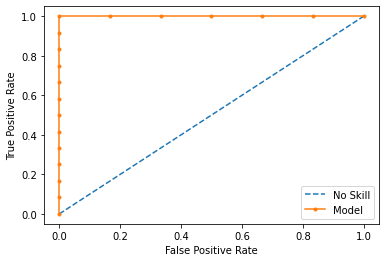

Ranking based on coefficient


['Blood_Urea_Nitrogen',
 'Absolute_Basophil',
 'Contrast-ngtdm',
 'Absolute_Reticulocyte',
 'Idmn-glcm',
 'ZoneVariance-glszm',
 'LargeAreaEmphasis-glszm',
 'LargeAreaLowGrayLevelEmphasis-glszm',
 'White_Blood_Cell_',
 'Abolute_Neutrophil',
 'Idn-glcm',
 'LeastAxisLength-shape',
 'Busyness-ngtdm',
 'Uniformity-firstorder',
 'Red_Cell_Distrubtion_Width_-_Coefficient',
 'JointEnergy-glcm',
 'LargeAreaHighGrayLevelEmphasis-glszm',
 'Hemoglobin',
 'Absolute_Monocyte',
 'Flatness-shape',
 'Red_Blood_Cell',
 'Median-firstorder',
 'GrayLevelNonUniformityNormalized-glrlm',
 'LowGrayLevelEmphasis-gldm',
 'Platelet',
 'Entropy-firstorder',
 'SmallAreaEmphasis-glszm',
 'Skewness-firstorder',
 'SumEntropy-glcm',
 'Hematocrit',
 'SizeZoneNonUniformityNormalized-glszm',
 'MIP-1beta',
 'JointEntropy-glcm',
 'IL-15',
 'GrayLevelNonUniformity-gldm',
 'SumAverage-glcm',
 'JointAverage-glcm',
 'TotalEnergy-firstorder',
 'LowGrayLevelRunEmphasis-glrlm',
 'Mean-firstorder',
 'Maximum-firstorder',
 'Range-f

Radiomics 52
Clinical Pathology 16
Immunology 6
Total 74


In [30]:
plot_tmp,coef = assess_MLmodel(LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5),data[var_cols+['Subject']],data[['Class','Subject']])
var_cols_tmp = coef.loc[coef.score_val > 0,'feature'].tolist()
display(var_cols_tmp)
print('Radiomics',[get_modality(n) for n in var_cols_tmp].count('Radiomics'))
print('Clinical Pathology',[get_modality(n) for n in var_cols_tmp].count('Clinical Pathology'))
print('Immunology',[get_modality(n) for n in var_cols_tmp].count('Immunology'))
print('Total',len(var_cols_tmp))

if False:
    # save feature set
    tmp_df = pd.DataFrame({'var':var_cols_tmp,'mod':[get_modality(n) for n in var_cols_tmp]})
    tmp_df.to_csv(os.path.join(PATH,'tables','feature_list_elasticnet.csv'))
    print(os.path.join(PATH,'tables','feature_list_elasticnet.csv'))

if False:
    #Write status message, change this anytime this part of the analysis changes
    status='elasticnet:'+str(len(var_cols_tmp))
    tmp_status_file=os.path.join('..','config','analysis_status','a_tmp.txt')
    with open(tmp_status_file,'w') as out_file:
        out_file.write(status)
    ml_log_tmp = ml_test(var_cols_tmp,data,master_log_file)
    del var_cols_tmp
    os.remove(tmp_status_file)

----- LogisticRegression(solver='liblinear') -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=1.000
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942

{'fit_time': array([0.01094317, 0.01130962, 0.01083183, 0.01112127, 0.01081872]),
 'score_time': array([0.01184773, 0.01162553, 0.01193953, 0.0121119 , 0.01232672]),
 'test_accuracy': array([0.83333333, 1.        , 0.94444444, 0.94444444, 0.94444444]),
 'test_f1': array([0.85714286, 1.        , 0.85714286, 0.95652174, 0.94117647]),
 'test_roc_auc': array([1., 1., 1., 1., 1.])}

Cross-validation Accuracy: 0.93 (+/- 0.11)
Cross-validation F1: 0.92 (+/- 0.11)
Cross-validation ROC AUC: 1.00 (+/- 0.00)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
tpr: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.         1.         1.         1.         1.
 1.        ]


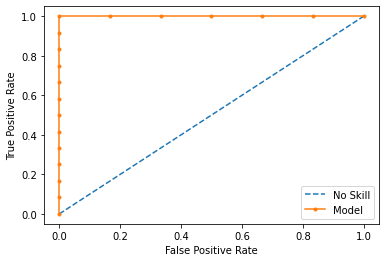

Ranking based on coefficient


['Blood_Urea_Nitrogen',
 'Absolute_Basophil',
 'Contrast-ngtdm',
 'Absolute_Reticulocyte',
 'White_Blood_Cell_',
 'Idmn-glcm',
 'LargeAreaLowGrayLevelEmphasis-glszm',
 'ZoneVariance-glszm',
 'LargeAreaEmphasis-glszm',
 'Abolute_Neutrophil',
 'Absolute_Monocyte',
 'Red_Cell_Distrubtion_Width_-_Coefficient',
 'Idn-glcm',
 'LeastAxisLength-shape',
 'Flatness-shape',
 'Red_Blood_Cell',
 'Hemoglobin',
 'Busyness-ngtdm',
 'MIP-1beta',
 'LargeAreaHighGrayLevelEmphasis-glszm',
 'Hematocrit',
 'JointEnergy-glcm',
 'Platelet',
 'Uniformity-firstorder',
 'Elongation-shape',
 'Maximum2DDiameterColumn-shape',
 'Complexity-ngtdm',
 'IL-15',
 'Maximum2DDiameterRow-shape',
 'Alanine_Aminotransferase',
 'IL-8',
 'Range-firstorder',
 'Maximum-firstorder',
 'LowGrayLevelEmphasis-gldm',
 'Median-firstorder',
 'Mean_Corpuscular_Volume',
 'IL-17a',
 'GrayLevelNonUniformityNormalized-glrlm',
 'SmallAreaEmphasis-glszm',
 'Red_Cell_Distrubtion_Width_-_Standard_De',
 'SizeZoneNonUniformityNormalized-glszm',
 'A

Radiomics 86
Clinical Pathology 24
Immunology 20
Total 130


In [31]:
plot_tmp,coef = assess_MLmodel(LogisticRegression(solver='liblinear', penalty='l2'),data[var_cols+['Subject']],data[['Class','Subject']])
var_cols_tmp = coef.loc[coef.score_val > 0,'feature'].tolist()
display(var_cols_tmp)
print('Radiomics',[get_modality(n) for n in var_cols_tmp].count('Radiomics'))
print('Clinical Pathology',[get_modality(n) for n in var_cols_tmp].count('Clinical Pathology'))
print('Immunology',[get_modality(n) for n in var_cols_tmp].count('Immunology'))
print('Total',len(var_cols_tmp))

if False:
    # save feature set
    tmp_df = pd.DataFrame({'var':var_cols_tmp,'mod':[get_modality(n) for n in var_cols_tmp]})
    tmp_df.to_csv(os.path.join(PATH,'tables','feature_list_rigid.csv'))
    print(os.path.join(PATH,'tables','feature_list_rigid.csv'))

if False:
    #Write status message, change this anytime this part of the analysis changes
    status='rigid:'+str(len(var_cols_tmp))
    tmp_status_file=os.path.join('..','config','analysis_status','a_tmp.txt')
    with open(tmp_status_file,'w') as out_file:
        out_file.write(status)
    ml_log_tmp = ml_test(var_cols_tmp,data,master_log_file)
    del var_cols_tmp
    os.remove(tmp_status_file)

----- DecisionTreeClassifier() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=0.958
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942' 'G26Y' 'G57L

{'fit_time': array([0.01086068, 0.01088309, 0.01038933, 0.01042819, 0.01124048]),
 'score_time': array([0.01840806, 0.01148677, 0.0115335 , 0.01145649, 0.01355052]),
 'test_accuracy': array([0.88888889, 0.72222222, 0.44444444, 0.94444444, 0.88888889]),
 'test_f1': array([0.90909091, 0.7826087 , 0.16666667, 0.96      , 0.9       ]),
 'test_roc_auc': array([0.91666667, 0.72222222, 0.4       , 0.91666667, 0.88888889])}

Cross-validation Accuracy: 0.78 (+/- 0.37)
Cross-validation F1: 0.74 (+/- 0.59)
Cross-validation ROC AUC: 0.77 (+/- 0.40)
fpr: [0. 0. 1.]
tpr: [0.         0.91666667 1.        ]


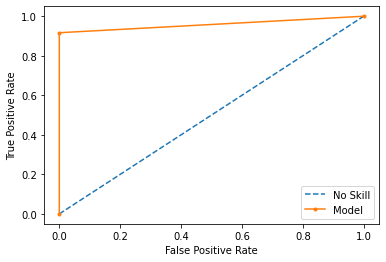

Not a valid model for feature ranking based on coefficient
Ranking based on feature importance


['Busyness-ngtdm', 'IL-1ra', 'Flatness-shape']

Radiomics 2
Clinical Pathology 0
Immunology 1
Total 3


In [32]:
plot_tmp,coef = assess_MLmodel(DecisionTreeClassifier(),data[var_cols+['Subject']],data[['Class','Subject']])
var_cols_tmp = coef.loc[coef.score_val > 0,'feature'].tolist()
display(var_cols_tmp)
print('Radiomics',[get_modality(n) for n in var_cols_tmp].count('Radiomics'))
print('Clinical Pathology',[get_modality(n) for n in var_cols_tmp].count('Clinical Pathology'))
print('Immunology',[get_modality(n) for n in var_cols_tmp].count('Immunology'))
print('Total',len(var_cols_tmp))

if False:
    # save feature set
    tmp_df = pd.DataFrame({'var':var_cols_tmp,'mod':[get_modality(n) for n in var_cols_tmp]})
    tmp_df.to_csv(os.path.join(PATH,'tables','feature_list_decisiontree.csv'))
    print(os.path.join(PATH,'tables','feature_list_decisiontree.csv'))

if False:
    #Write status message, change this anytime this part of the analysis changes
    status='DecisionTreeFI:'+str(len(var_cols_tmp))
    tmp_status_file=os.path.join('..','config','analysis_status','a_tmp.txt')
    with open(tmp_status_file,'w') as out_file:
        out_file.write(status)
    ml_log_tmp = ml_test(var_cols_tmp,data,master_log_file)
    del var_cols_tmp
    os.remove(tmp_status_file)

----- RandomForestClassifier() -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing subjects: 6
Features: 137
ROC AUC=0.972
Train: ['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
Test: ['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Train_Exposed: 24 Train_Mock: 18
Test_Exposed: 12 Test_Mock: 6
Train: ['B03781' 'B03819' 'B03828' 'B03859' 'B03928' 'B03942' 'B03955' 'B03959'
 'B03989' 'G57L' 'G57N' 'H32F' 'H38Y' 'H54R']
Test: ['B03757' 'G21E' 'G26Y' 'G974' 'H56N' 'H89K']
Train_Exposed: 27 Train_Mock: 15
Test_Exposed: 9 Test_Mock: 9
Train: ['B03757' 'B03781' 'B03819' 'B03828' 'B03859' 'B03955' 'B03959' 'B03989'
 'G21E' 'G974' 'H32F' 'H38Y' 'H54R' 'H56N']
Test: ['B03928' 'B03942' 'G26Y' 'G57L

{'fit_time': array([0.18766618, 0.18553424, 0.18625689, 0.18689156, 0.18615031]),
 'score_time': array([0.04283309, 0.03939247, 0.03949714, 0.03943634, 0.03938246]),
 'test_accuracy': array([0.83333333, 0.94444444, 0.72222222, 1.        , 0.94444444]),
 'test_f1': array([0.88      , 0.94736842, 0.54545455, 1.        , 0.94736842]),
 'test_roc_auc': array([0.96527778, 1.        , 0.8       , 1.        , 1.        ])}

Cross-validation Accuracy: 0.89 (+/- 0.20)
Cross-validation F1: 0.86 (+/- 0.33)
Cross-validation ROC AUC: 0.95 (+/- 0.16)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.16666667 0.33333333
 0.33333333 0.5        0.66666667 0.83333333 1.        ]
tpr: [0.         0.08333333 0.16666667 0.33333333 0.5        0.58333333
 0.66666667 0.75       0.83333333 0.91666667 0.91666667 0.91666667
 1.         1.         1.         1.         1.        ]


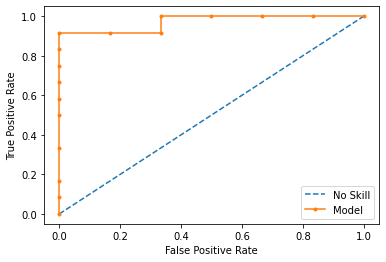

Not a valid model for feature ranking based on coefficient
Ranking based on feature importance


['Busyness-ngtdm',
 'RobustMeanAbsoluteDeviation-firstorder',
 'LowGrayLevelEmphasis-gldm',
 'Strength-ngtdm',
 'Kurtosis-firstorder',
 'LowGrayLevelRunEmphasis-glrlm',
 'Uniformity-firstorder',
 'RootMeanSquared-firstorder',
 'Correlation-glcm',
 'LargeAreaLowGrayLevelEmphasis-glszm',
 'SmallDependenceHighGrayLevelEmphasis-gldm',
 'Blood_Urea_Nitrogen',
 'HighGrayLevelEmphasis-gldm',
 'SumEntropy-glcm',
 'GrayLevelNonUniformityNormalized-glrlm',
 'InterquartileRange-firstorder',
 'LargeDependenceHighGrayLevelEmphasis-gldm',
 'LongRunHighGrayLevelEmphasis-glrlm',
 'Median-firstorder',
 'Complexity-ngtdm',
 'Entropy-firstorder',
 'Skewness-firstorder',
 'Coarseness-ngtdm',
 'JointAverage-glcm',
 'GrayLevelNonUniformity-gldm',
 'Maximum-firstorder',
 'IL-15',
 'Platelet',
 'Absolute_Lymphocyte',
 'TotalEnergy-firstorder',
 'VoxelVolume-shape',
 'ShortRunLowGrayLevelEmphasis-glrlm',
 'DependenceNonUniformity-gldm',
 'Mean-firstorder',
 'Imc1-glcm',
 'Autocorrelation-glcm',
 '10Percentile-

Radiomics 42
Clinical Pathology 4
Immunology 3
Total 49


In [33]:
plot_tmp,coef = assess_MLmodel(RandomForestClassifier(),data[var_cols+['Subject']],data[['Class','Subject']])
var_cols_tmp = coef.loc[coef.score_val > 0,'feature'].tolist()
display(var_cols_tmp)
print('Radiomics',[get_modality(n) for n in var_cols_tmp].count('Radiomics'))
print('Clinical Pathology',[get_modality(n) for n in var_cols_tmp].count('Clinical Pathology'))
print('Immunology',[get_modality(n) for n in var_cols_tmp].count('Immunology'))
print('Total',len(var_cols_tmp))

if False:
    # save feature set
    tmp_df = pd.DataFrame({'var':var_cols_tmp,'mod':[get_modality(n) for n in var_cols_tmp]})
    tmp_df.to_csv(os.path.join(PATH,'tables','feature_list_randomforest.csv'))
    print(os.path.join(PATH,'tables','feature_list_randomforest.csv'))

if False:
    #Write status message, change this anytime this part of the analysis changes
    status='RandomForestFI:'+str(len(var_cols_tmp))
    tmp_status_file=os.path.join('..','config','analysis_status','a_tmp.txt')
    with open(tmp_status_file,'w') as out_file:
        out_file.write(status)
    ml_log_tmp = ml_test(var_cols_tmp,data,master_log_file)
    del var_cols_tmp
    os.remove(tmp_status_file)

----- XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None) -----
['B03757' 'B03781' 'B03828' 'B03942' 'B03955' 'B03989' 'G21E' 'G26Y'
 'G57L' 'G57N' 'G974' 'H32F' 'H56N' 'H89K']
['B03819' 'B03859' 'B03928' 'B03959' 'H38Y' 'H54R']
Training samples: 42 ( 24  infected)
Testing sample: 18 ( 12  infected)
Unique training subjects: 14
Unique testing

{'fit_time': array([8.53422308, 8.54297137, 7.46358299, 8.06773543, 7.74743176]),
 'score_time': array([0.06400943, 0.05495477, 0.10741186, 0.08179069, 0.07519126]),
 'test_accuracy': array([1.        , 0.94444444, 0.77777778, 0.88888889, 0.94444444]),
 'test_f1': array([1.        , 0.94736842, 0.5       , 0.92307692, 0.94736842]),
 'test_roc_auc': array([1.        , 0.99382716, 0.84444444, 0.97916667, 1.        ])}

Cross-validation Accuracy: 0.91 (+/- 0.15)
Cross-validation F1: 0.86 (+/- 0.37)
Cross-validation ROC AUC: 0.96 (+/- 0.12)
fpr: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.16666667 0.33333333 0.66666667 0.83333333 1.        ]
tpr: [0.         0.08333333 0.16666667 0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667 1.
 1.         1.         1.         1.         1.        ]


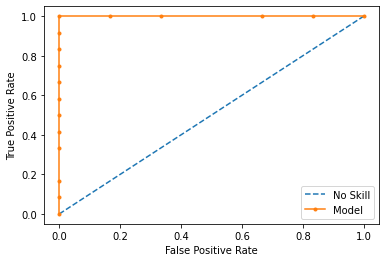

Not a valid model for feature ranking based on coefficient
Ranking based on feature importance


['Busyness-ngtdm',
 'Strength-ngtdm',
 'InterquartileRange-firstorder',
 'Correlation-glcm',
 'Idmn-glcm',
 'Blood_Urea_Nitrogen',
 'Absolute_Reticulocyte',
 'TotalEnergy-firstorder',
 'IL-15',
 'Maximum2DDiameterRow-shape',
 'White_Blood_Cell_',
 'Contrast-glcm',
 'IL-1ra']

Radiomics 8
Clinical Pathology 3
Immunology 2
Total 13


In [34]:
plot_tmp,coef = assess_MLmodel(XGBClassifier(use_label_encoder=False,eval_metric='logloss'),data[var_cols+['Subject']],data[['Class','Subject']])
var_cols_tmp = coef.loc[coef.score_val > 0,'feature'].tolist()
display(var_cols_tmp)
print('Radiomics',[get_modality(n) for n in var_cols_tmp].count('Radiomics'))
print('Clinical Pathology',[get_modality(n) for n in var_cols_tmp].count('Clinical Pathology'))
print('Immunology',[get_modality(n) for n in var_cols_tmp].count('Immunology'))
print('Total',len(var_cols_tmp))

if False:
    # save feature set
    tmp_df = pd.DataFrame({'var':var_cols_tmp,'mod':[get_modality(n) for n in var_cols_tmp]})
    tmp_df.to_csv(os.path.join(PATH,'tables','feature_list_xgboost.csv'))
    print(os.path.join(PATH,'tables','feature_list_xgboost.csv'))

if False:
    #Write status message, change this anytime this part of the analysis changes
    status='XGBFI:'+str(len(var_cols_tmp))
    tmp_status_file=os.path.join('..','config','analysis_status','a_tmp.txt')
    with open(tmp_status_file,'w') as out_file:
        out_file.write(status)
    ml_log_tmp = ml_test(var_cols_tmp,data,master_log_file)
    del var_cols_tmp
    os.remove(tmp_status_file)

# Miscellaneous Views

In [35]:
var_cols

['VoxelVolume-shape',
 'Maximum3DDiameter-shape',
 'Compactness2-shape',
 'MeshVolume-shape',
 'MajorAxisLength-shape',
 'Sphericity-shape',
 'LeastAxisLength-shape',
 'Elongation-shape',
 'Compactness1-shape',
 'Flatness-shape',
 'SurfaceArea-shape',
 'MinorAxisLength-shape',
 'Maximum2DDiameterColumn-shape',
 'SphericalDisproportion-shape',
 'Maximum2DDiameterRow-shape',
 'JointAverage-glcm',
 'Autocorrelation-glcm',
 'JointEntropy-glcm',
 'ClusterShade-glcm',
 'Idmn-glcm',
 'JointEnergy-glcm',
 'Contrast-glcm',
 'DifferenceVariance-glcm',
 'Idn-glcm',
 'Idm-glcm',
 'Correlation-glcm',
 'SumAverage-glcm',
 'SumEntropy-glcm',
 'MCC-glcm',
 'SumSquares-glcm',
 'ClusterProminence-glcm',
 'Imc2-glcm',
 'Imc1-glcm',
 'DifferenceAverage-glcm',
 'Id-glcm',
 'ClusterTendency-glcm',
 'GrayLevelVariance-gldm',
 'HighGrayLevelEmphasis-gldm',
 'DependenceEntropy-gldm',
 'DependenceNonUniformity-gldm',
 'GrayLevelNonUniformity-gldm',
 'SmallDependenceHighGrayLevelEmphasis-gldm',
 'LargeDependence

In [37]:
# # Uncomment to save var_col_list
# print(var_cols_LogFI)
# # save lists
# with open('lists_LogFI.pkl', 'wb') as f:
#     pickle.dump([var_cols_LogFI], f)

In [38]:
len(var_cols_LogFI)

35

In [39]:
var_cols_LogFI

['Blood_Urea_Nitrogen',
 'Mean_Platelet_Volume_',
 'IFN-Alpha',
 'Creatinine_',
 'Contrast.1',
 'LargeDependenceLowGrayLevelEmphasis',
 'LongRunLowGrayLevelEmphasis',
 'IL-15',
 'Idmn',
 'Absolute_Reticulocyte',
 'Complexity',
 'SmallAreaEmphasis',
 'Mean_Corpuscular_Hemoglobin',
 'SizeZoneNonUniformityNormalized',
 'Percent_Eosinophil',
 'Flatness',
 'Idn',
 'Percent_Reticulocyte',
 'ZoneVariance',
 'LargeAreaEmphasis',
 'Maximum2DDiameterRow',
 'IL-1ra',
 'Platelet_Distribution_Width',
 'LargeAreaLowGrayLevelEmphasis',
 'Platelet_Large_Cell_-_Ratio',
 'TotalEnergy',
 'White_Blood_Cell_',
 'IL-8',
 'IL-1b',
 'Maximum',
 'Range',
 'Median',
 'MCP-1',
 'Percent_Lymphocyte',
 'Hemoglobin']